In [18]:
!pip install pytesseract
import pytesseract
import cv2
import numpy as np

You are using pip version 18.1, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


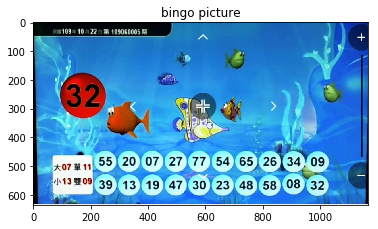

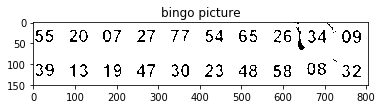

55 20 07 27 77 54 65 26 34 09 39 13 19 47 30 23 48 58 08 32  


In [40]:
from PIL import Image
from matplotlib import pyplot as plt
import re
img = Image.open('1.jpg')
plt.imshow(img)
plt.title('bingo picture')
plt.show()
# 模式L”为灰色图像，它的每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。
img = img.convert('L')
 
# 自定义灰度界限，大于这个值为黑色，小于这个值为白色
threshold = 50
 
table = []
for i in range(256):
    if i < threshold:
        table.append(0)
    else:
        table.append(1)
 
img = img.point(table, '1')


area = (225, 450,
        1030, 600)
cropped_img = img.crop(area)

plt.imshow(cropped_img)
plt.title('bingo picture')
plt.show()
num = pytesseract.image_to_string(cropped_img)
num = re.sub(r'\D', " ", num)
print (num)

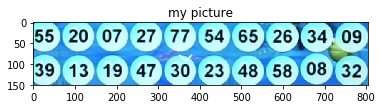

55] 20) 07) 27) 77/54) 65) 261 34% 09
39] 13) 19) 47) 30) 23) 48) 58) 08) 32



In [8]:
from PIL import Image
from matplotlib import pyplot as plt
img = Image.open('1.jpg')
 
area = (225, 450,
        1030, 600)
cropped_img = img.crop(area)
plt.imshow(cropped_img)
plt.title('my picture')
plt.show()
print(pytesseract.image_to_string(cropped_img))

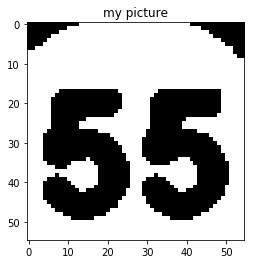

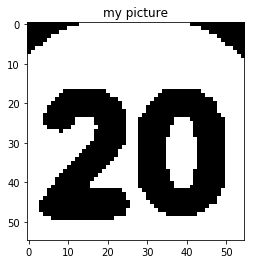

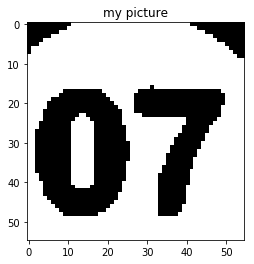

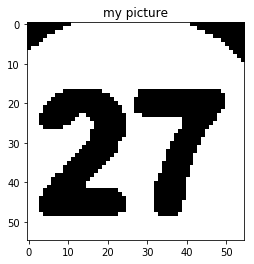

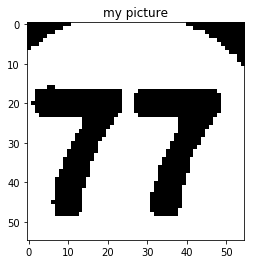

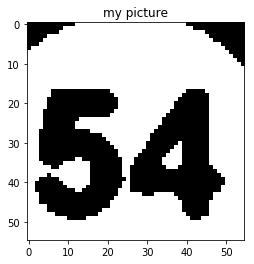

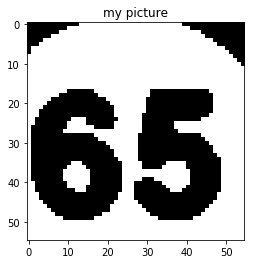

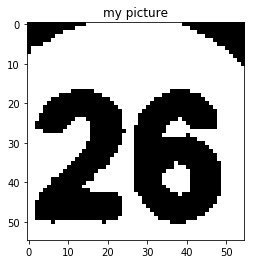

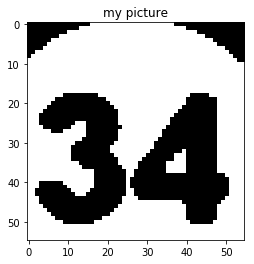

34



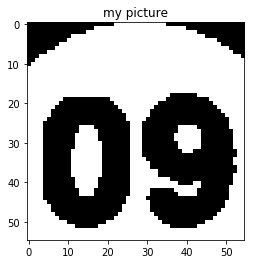

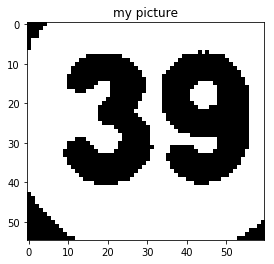

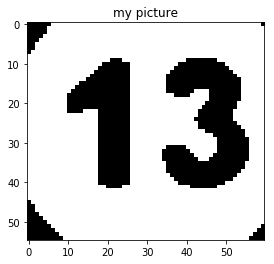

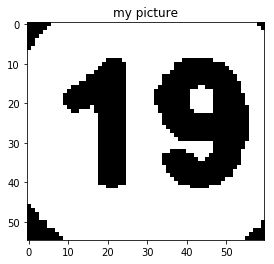

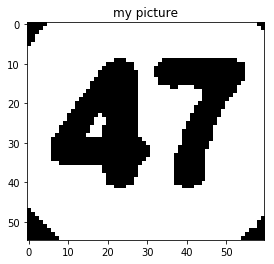

47



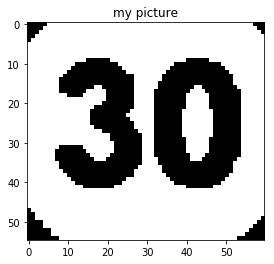

30



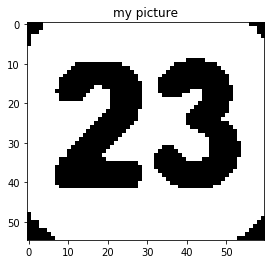

23



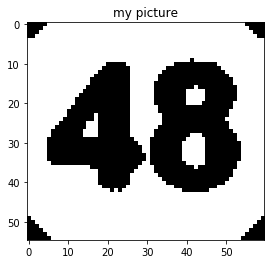

48



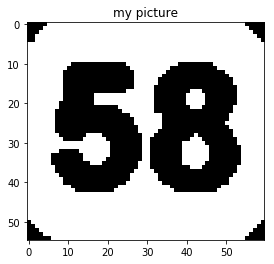

58



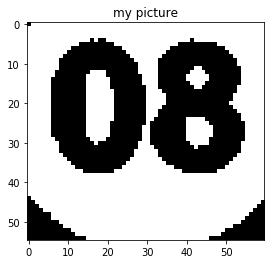

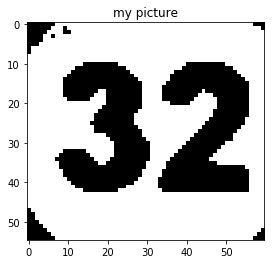

32



In [6]:
for i in range(2):
    for j in range(10):
        if i==1:
            area = ( (j*80)+(j*2)+220, 540,
                (j*80)+(j*2)+280, 595)
        else:
            area = ( (j*80)+(j*2)+225, 450,
               (j*80)+(j*2)+280, 505)
        cropped_img = img.crop(area)
        plt.imshow(cropped_img)
        plt.title('my picture')
        plt.show()
        print(pytesseract.image_to_string(cropped_img))


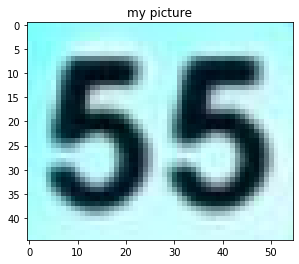

In [52]:
area = (225, 460,
        280, 505)
cropped_img = img.crop(area)

plt.imshow(cropped_img)
plt.title('my picture')
plt.show()

In [49]:
import pytesseract
print(pytesseract.image_to_string(cropped_img))

20



In [67]:
#encoding:utf-8
import cv2  
import numpy as np  

#读取图片
src = cv2.imread('test02.png', cv2.IMREAD_UNCHANGED)

#设置卷积核
kernel = np.ones((5,5), np.uint8)

#图像膨胀处理
erosion = cv2.dilate(src, kernel)

#显示图像
cv2.imshow("src", src)
cv2.imshow("result", erosion)

#等待显示
cv2.waitKey(0)
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'cv2'